In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [9]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted dimensions here
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)  # Adjusted dimensions here
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
def train_model(model, dataloader, criterion, optimizer, iteration, epochs=5):
    model.train()
    accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Evaluar en cada época para registrar todas las accuracies
        accuracy = evaluate_model(model, test_loader)
        accuracies.append(accuracy)

    print(f'Accuracy: {max(accuracies):.2%}')
    return total_loss / len(dataloader), accuracies

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    return correct / total

In [12]:
def create_prune_mask(model, prune_percentage=0.2):
    mask = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            threshold = torch.quantile(param.abs(), prune_percentage)
            mask[name] = (param.abs() > threshold).float().to(device)
    return mask

def prune_model(model, mask):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in mask:
                param.data *= mask[name]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 5
iterations = 10

transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
results = {}

model = SimpleMLP().to(device)
model_entrenado = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_inicial = model.state_dict()
prune_percentages = [80, 70, 60, 50, 40, 30, 20, 15, 10, 8, 5, 3]
iterations = 5

def run_experiment():
    global results
    print(f"===== Modelo original =====")
    _, accuracies_original = train_model(model, train_loader, criterion, optimizer, 0, epochs)

    print(f"Final accuracies for original model: {accuracies_original}")
    results[100] = {
        "accuracies": accuracies_original
    }
    
    for prune_percentage in prune_percentages:
        model.load_state_dict(model_inicial)
        print(f"===== Pruning al {prune_percentage}% =====")

        accuracies_pruned = []
        for iteration in range(1, iterations + 1):
            print(f"Iteración {iteration}/{iterations}")

            prune_mask = create_prune_mask(model_entrenado, prune_percentage / 100.0)
            prune_model(model, prune_mask)

            _, accuracies = train_model(model, train_loader, criterion, optimizer, iteration, epochs)
            accuracies_pruned.extend(accuracies)

        results[prune_percentage] = {
            "accuracies": accuracies_pruned
        }

        print(f"Final accuracies for pruning at {prune_percentage}%: {accuracies_pruned}")

run_experiment()

===== Modelo original =====
Accuracy: 70.05%
Final accuracies for original model: [0.5639, 0.6191, 0.6776, 0.7005, 0.6993]
===== Pruning al 80% =====
Iteración 1/5
Accuracy: 68.69%
Iteración 2/5
Accuracy: 72.39%
Iteración 3/5
Accuracy: 72.99%
Iteración 4/5
Accuracy: 74.21%
Iteración 5/5
Accuracy: 73.28%
Final accuracies for pruning at 80%: [0.4872, 0.6004, 0.6508, 0.6869, 0.6856, 0.6056, 0.6838, 0.7021, 0.7239, 0.708, 0.6831, 0.7045, 0.7113, 0.7272, 0.7299, 0.6922, 0.7001, 0.7354, 0.7115, 0.7421, 0.7106, 0.7232, 0.7328, 0.7266, 0.7288]
===== Pruning al 70% =====
Iteración 1/5
Accuracy: 73.87%
Iteración 2/5
Accuracy: 73.10%
Iteración 3/5
Accuracy: 73.48%
Iteración 4/5
Accuracy: 72.10%
Iteración 5/5
Accuracy: 72.12%
Final accuracies for pruning at 70%: [0.7179, 0.7237, 0.7289, 0.7387, 0.7375, 0.7159, 0.7252, 0.731, 0.7295, 0.7208, 0.719, 0.718, 0.7348, 0.7227, 0.728, 0.7095, 0.7138, 0.721, 0.7086, 0.7183, 0.719, 0.7212, 0.7185, 0.7112, 0.7137]
===== Pruning al 60% =====
Iteración 1/5
Acc

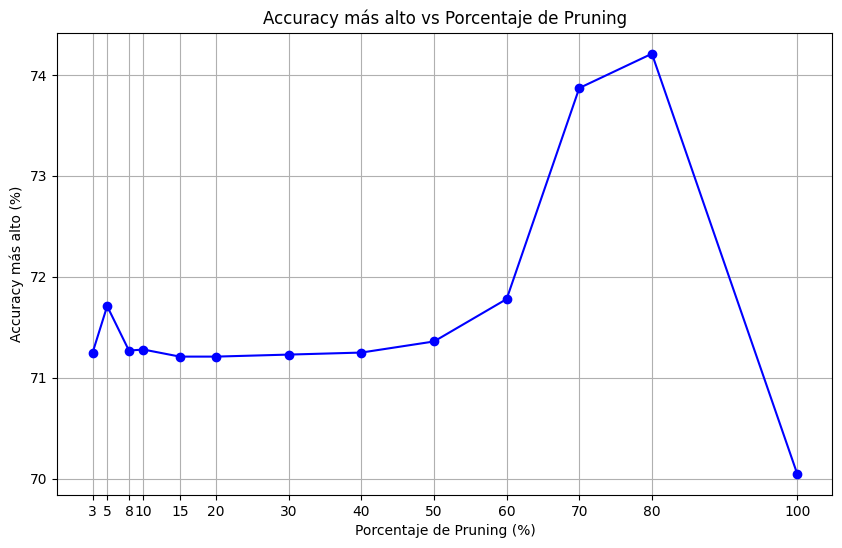

In [15]:
# Función para obtener la mejor accuracy de cada porcentaje de pruning
def extract_best_accuracies(results):
    best_accuracies = []
    pruning_percentages = []
    for percentage, data in results.items():
        pruning_percentages.append(percentage)
        best_accuracy = max(data["accuracies"])  # Mejor accuracy de todas las iteraciones para ese porcentaje
        best_accuracies.append(best_accuracy)
    return pruning_percentages, best_accuracies

# Extraer los datos
pruning_percentages, best_accuracies = extract_best_accuracies(results)

# Generar la gráfica
plt.figure(figsize=(10, 6))
plt.plot(pruning_percentages, [acc * 100 for acc in best_accuracies], marker='o', color='b')
plt.title('Accuracy más alto vs Porcentaje de Pruning')
plt.xlabel('Porcentaje de Pruning (%)')
plt.ylabel('Accuracy más alto (%)')
plt.grid(True)
plt.xticks(pruning_percentages)
plt.show()
